# *Introduction*

# Build the environment

In [ ]:
# Install TerraTorch and dependencies
!pip install terratorch
!pip install gdown tensorboard lightning

In [ ]:
# Import libraries
import os
import shutil
from pathlib import Path
import numpy as np
from PIL import Image
import torch
import gdown
import lightning.pytorch as pl
import matplotlib.pyplot as plt
from terratorch.datamodules import GenericNonGeoClassificationDataModule
from terratorch.tasks import ClassificationTask
import rasterio
import zipfile
import warnings
import albumentations as A
from albumentations.pytorch import ToTensorV2

warnings.filterwarnings("ignore")

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


# Adding Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

DATASET_ZIP = "/content/drive/MyDrive/GFM/Data_Romania.zip"

if not os.path.exists(DATASET_ZIP):
    raise FileNotFoundError(f"Dataset not found at {DATASET_ZIP}")

# Extract dataset
if not os.path.exists("Data"):
    print("Extracting dataset...")
    with zipfile.ZipFile(DATASET_ZIP, 'r') as zip_ref:
        zip_ref.extractall(".")
    print("✅ Extraction complete!")

# Find data root
if os.path.exists("Data"):
    DATA_ROOT = Path("Data")
elif os.path.exists("data_Romania/Data"):
    DATA_ROOT = Path("data_Romania/Data")
else:
    raise ValueError("Cannot find Data folder!")

print(f"✅ DATA_ROOT: {DATA_ROOT}")

Mounted at /content/drive
Extracting dataset...
✅ Extraction complete!
✅ DATA_ROOT: Data


In [ ]:
# Configuration
PREPARED_ROOT = Path("./prepared")
TRAIN_DIR = PREPARED_ROOT / "train"
VAL_DIR = PREPARED_ROOT / "val"
TEST_DIR = PREPARED_ROOT / "test"
OUTPUT_PATH = "./output/terramind_romania"

# Hyperparameters
IMG_SIZE = 224
NUM_CLASSES = 10  # Adjust based on your LUCAS classes
BATCH_SIZE = 8
MAX_EPOCHS = 50
LEARNING_RATE = 1e-4
NUM_WORKERS = 2

# Data split ratios
TRAIN_RATIO = 0.7
VAL_RATIO = 0.2
TEST_RATIO = 0.1

print("✅ Configuration set")

✅ Configuration set


# Database Split

In [ ]:
# Create train/val/test splits
pl.seed_everything(42)

if not PREPARED_ROOT.exists():
    PREPARED_ROOT.mkdir(parents=True)
    TRAIN_DIR.mkdir(exist_ok=True)
    VAL_DIR.mkdir(exist_ok=True)
    TEST_DIR.mkdir(exist_ok=True)

    print("\nCreating train/val/test splits...")
    classes = sorted([d.name for d in DATA_ROOT.iterdir() if d.is_dir()])
    print(f"Found classes: {classes}")

    for cls in classes:
        cls_path = DATA_ROOT / cls
        images = sorted([f.name for f in cls_path.iterdir() if f.suffix.lower() in ['.tif', '.tiff']])

        if len(images) == 0:
            print(f"Warning: No images found for class {cls}")
            continue

        # Shuffle and split
        np.random.shuffle(images)
        n_train = int(len(images) * TRAIN_RATIO)
        n_val = int(len(images) * VAL_RATIO)

        train_imgs = images[:n_train]
        val_imgs = images[n_train:n_train + n_val]
        test_imgs = images[n_train + n_val:]

        (TRAIN_DIR / cls).mkdir(exist_ok=True)
        (VAL_DIR / cls).mkdir(exist_ok=True)
        (TEST_DIR / cls).mkdir(exist_ok=True)

        for img in train_imgs:
            shutil.copy(cls_path / img, TRAIN_DIR / cls / img)
        for img in val_imgs:
            shutil.copy(cls_path / img, VAL_DIR / cls / img)
        for img in test_imgs:
            shutil.copy(cls_path / img, TEST_DIR / cls / img)

        print(f"Class {cls}: {len(images)} images (train={len(train_imgs)}, val={len(val_imgs)}, test={len(test_imgs)})")

    print("✅ Dataset split created")
else:
    print("✅ Dataset split already exists")

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42



Creating train/val/test splits...
Found classes: ['1', '10', '2', '3', '4', '5', '6', '7', '8', '9']
Class 1: 10 images (train=7, val=2, test=1)
Class 10: 10 images (train=7, val=2, test=1)
Class 2: 10 images (train=7, val=2, test=1)
Class 3: 10 images (train=7, val=2, test=1)
Class 4: 10 images (train=7, val=2, test=1)
Class 5: 10 images (train=7, val=2, test=1)
Class 6: 10 images (train=7, val=2, test=1)
Class 7: 10 images (train=7, val=2, test=1)
Class 8: 10 images (train=7, val=2, test=1)
Class 9: 10 images (train=7, val=2, test=1)
✅ Dataset split created


# Database Statistics

In [ ]:
# Compute dataset statistics
all_pixels = []
num_bands = None

for cls in os.listdir(TRAIN_DIR):
    cls_folder = TRAIN_DIR / cls
    if not cls_folder.is_dir():
        continue

    for img_file in cls_folder.iterdir():
        if img_file.suffix.lower() not in ['.tif', '.tiff']:
            continue

        with rasterio.open(img_file) as src:
            img = src.read()
            if num_bands is None:
                num_bands = img.shape[0]

            # Flatten spatial dimensions
            img_flat = img.reshape(img.shape[0], -1).T
            all_pixels.append(img_flat)

if all_pixels:
    all_pixels = np.vstack(all_pixels)
    means = np.mean(all_pixels, axis=0).tolist()
    stds = np.std(all_pixels, axis=0).tolist()

    # Add a small epsilon for zero std
    stds = [max(s, 1e-6) for s in stds]
else:
    # Fallback to pre-training values for HLS S2L2A
    means = [1390.458, 1503.317, 1718.197, 1853.910, 2199.100, 2779.975]
    stds = [2106.761, 2141.107, 2038.973, 2134.138, 2085.321, 1889.926]

print(f"✅ Number of bands: {len(means)}")
print(f"✅ Means: {means}")
print(f"✅ Stds: {stds}")

✅ Number of bands: 7
✅ Means: [0.18062925338745117, 0.17749503254890442, 0.16650594770908356, 0.2213936299085617, 0.08539421856403351, 0.06433480978012085, 0.0]
✅ Stds: [0.2793446183204651, 0.27696073055267334, 0.2820151150226593, 0.26269158720970154, 0.08070189505815506, 0.05866345018148422, 1e-06]


# Datamodule

In [ ]:
# Define data augmentation transforms
train_transform = A.Compose([
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    ToTensorV2()  # ✅ DataModule handles normalization
])

val_test_transform = A.Compose([
    A.Normalize(mean=means, std=stds),
    ToTensorV2()
])

# Create DataModule
datamodule = GenericNonGeoClassificationDataModule(
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    train_data_root=str(TRAIN_DIR),
    val_data_root=str(VAL_DIR),
    test_data_root=str(TEST_DIR),
    means=means,  # ✅ NOW REQUIRED
    stds=stds,    # ✅ NOW REQUIRED
    num_classes=NUM_CLASSES,
    img_grep="*.tif*",
    train_transform=train_transform,
    val_transform=val_test_transform,
    test_transform=val_test_transform,
)

# Setup datasets
datamodule.setup("fit")
print(f"✅ Train dataset size: {len(datamodule.train_dataset)}")
print(f"✅ Val dataset size: {len(datamodule.val_dataset)}")

datamodule.setup("test")
print(f"✅ Test dataset size: {len(datamodule.test_dataset)}")

✅ Train dataset size: 70
✅ Val dataset size: 20
✅ Test dataset size: 10


# Model Configuration

In [ ]:
# Determine modality based on number of bands
num_channels = len(means)
print(f"Number of channels: {num_channels}")

# Map common band counts to modalities
# HLS S2L2A typically has 6 or 12 bands
if num_channels == 6:
    modality = "S2L2A"
    band_names = ["BLUE", "GREEN", "RED", "NIR_NARROW", "SWIR_1", "SWIR_2"]
elif num_channels == 7:
    modality = "S2L2A"
    band_names = ["BLUE", "GREEN", "RED", "NIR_NARROW", "SWIR_1", "SWIR_2", "NIR_BROAD"]
elif num_channels == 12:
    modality = "S2L2A"
    band_names = ["BLUE", "GREEN", "RED", "RED_EDGE_1", "RED_EDGE_2", "RED_EDGE_3",
                  "NIR_NARROW", "NIR_BROAD", "SWIR_1", "SWIR_2", "CIRRUS", "COASTAL_AEROSOL"]
elif num_channels == 13:
    modality = "S2L1C"
    band_names = ["COASTAL_AEROSOL", "BLUE", "GREEN", "RED", "RED_EDGE_1", "RED_EDGE_2",
                  "RED_EDGE_3", "NIR_NARROW", "NIR_BROAD", "WATER_VAPOR", "CIRRUS", "SWIR_1", "SWIR_2"]
else:
    # Generic band names
    modality = "S2L2A"
    band_names = [f"BAND_{i+1}" for i in range(num_channels)]

print(f"Using modality: {modality}")
print(f"Band names: {band_names}")

Number of channels: 7
Using modality: S2L2A
Band names: ['BLUE', 'GREEN', 'RED', 'NIR_NARROW', 'SWIR_1', 'SWIR_2', 'NIR_BROAD']


In [ ]:
# TerraMind Classification Task
# Choose model variant: terramind_v1_tiny (faster) or terramind_v1_base (better performance)
MODEL_VARIANT = "terramind_v1_large"  # or "terramind_v1_base" or "terramind_v1_large"

# Select indices based on model variant
if "tiny" in MODEL_VARIANT:
    select_indices = [2, 5, 8, 11]  # For tiny variant
elif "base" in MODEL_VARIANT:
    select_indices = [2, 5, 8, 11]  # For base variant
elif "large" in MODEL_VARIANT:
    select_indices = [5, 11, 17, 23]  # For large variant
else:
    select_indices = [2, 5, 8, 11]  # Default

print(f"Using model variant: {MODEL_VARIANT}")
print(f"SelectIndices: {select_indices}")

Using model variant: terramind_v1_large
SelectIndices: [5, 11, 17, 23]


In [ ]:
# Create TerraMind Classification Task
task = ClassificationTask(
    model_factory="EncoderDecoderFactory",
    model_args={
        # TerraMind backbone
        "backbone": MODEL_VARIANT,
        "backbone_pretrained": True,
        "backbone_modalities": [modality],  # Single modality for classification
        "backbone_bands": {modality: band_names},  # Define bands for the modality

        # Necks - transform ViT tokens to features suitable for classification
        "necks": [
            {
                "name": "SelectIndices",
                "indices": select_indices
            },
            {
                "name": "ReshapeTokensToImage",
                "remove_cls_token": False  # TerraMind doesn't use CLS token
            },
        ],

        # Decoder - Identity for classification (just passes features through)
        "decoder": "IdentityDecoder",

        # Classification Head
        "head_dropout": 0.1,
        "num_classes": NUM_CLASSES,
    },

    # Training configuration
    loss="ce",  # Cross-entropy loss for multi-class classification
    optimizer="AdamW",
    lr=LEARNING_RATE,
    optimizer_hparams={"weight_decay": 0.05},
    ignore_index = -100,

    # Fine-tuning strategy
    freeze_backbone=False,  # Set to True to freeze backbone and only train head (faster)
    freeze_decoder=False,

    # Optional: define class names for better logging
    class_names=[str(i+1) for i in range(NUM_CLASSES)],
)

print("✅ TerraMind Classification Task created")
print(f"Model: {MODEL_VARIANT}")
print(f"Modality: {modality}")
print(f"Number of classes: {NUM_CLASSES}")

TerraMind_v1_large.pt:   0%|          | 0.00/3.79G [00:00<?, ?B/s]

✅ TerraMind Classification Task created
Model: terramind_v1_large
Modality: S2L2A
Number of classes: 10


# Configure Trainer

In [ ]:
# Callbacks
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=f"{OUTPUT_PATH}/checkpoints/",
    mode="max",
    monitor="val/Accuracy",  # Monitor validation accuracy
    filename="best-acc-{epoch:02d}-{val/Accuracy:.4f}",
    save_top_k=1,
    save_weights_only=True,
)

early_stop_callback = pl.callbacks.EarlyStopping(
    monitor="val/Accuracy",
    patience=10,
    mode="max",
    verbose=True
)

# Logger
logger = pl.loggers.TensorBoardLogger(
    save_dir=OUTPUT_PATH,
    name="terramind_romania_classification"
)

# Trainer
trainer = pl.Trainer(
    accelerator="auto",
    strategy="auto",
    devices=1,
    precision="16-mixed",  # Mixed precision for faster training
    max_epochs=MAX_EPOCHS,
    logger=logger,
    callbacks=[
        checkpoint_callback,
        early_stop_callback,
        pl.callbacks.RichProgressBar()
    ],
    log_every_n_steps=5,
    default_root_dir=OUTPUT_PATH,
)

print("✅ Trainer configured")

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


✅ Trainer configured


# Train

In [27]:
# Start training
print("🚀 Starting training...\n")
trainer.fit(task, datamodule=datamodule)
print("\n✅ Training completed!")

Epoch 10/49 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 0:00:03 • 0:00:00 2.53it/s v_num: 2.000

INFO: Monitored metric val/Accuracy did not improve in the last 10 records. Best score: 0.100. Signaling Trainer to stop.
INFO:lightning.pytorch.callbacks.early_stopping:Monitored metric val/Accuracy did not improve in the last 10 records. Best score: 0.100. Signaling Trainer to stop.



✅ Training completed!


# Test

In [28]:
# Test the model with best checkpoint
best_ckpt_path = checkpoint_callback.best_model_path
print(f"Best checkpoint: {best_ckpt_path}")

test_results = trainer.test(task, datamodule=datamodule, ckpt_path=best_ckpt_path)
print("\n✅ Testing completed!")
print("\nTest Results:")
for key, value in test_results[0].items():
    print(f"  {key}: {value:.4f}")

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/Accuracy       │    0.10000000149011612    │
│    test/Accuracy_Micro    │    0.10000000149011612    │
│   test/Class_Accuracy_1   │            0.0            │
│  test/Class_Accuracy_10   │            0.0            │
│   test/Class_Accuracy_2   │            0.0            │
│   test/Class_Accuracy_3   │            1.0            │
│   test/Class_Accuracy_4   │            0.0            │
│   test/Class_Accuracy_5   │            0.0            │
│   test/Class_Accuracy_6   │            0.0            │
│   test/Class_Accuracy_7   │            0.0            │
│   test/Class_Accuracy_8   │            0.0            │
│   test/Class_Accuracy_9   │            0.0            │
│      test/Class_F1_1      │            0.0            │
│     test/Class_F1_10      │            0.0            │
│      test/Class_F1_2      │            0.0            │
│      test/Class_F1_3      │    0.1818181872367859     │
│      test/Class_F1_4      │            0.0            │
│      test/Class_F1_5      │            0.0            │
│      test/Class_F1_6      │            0.0            │
│      test/Class_F1_7      │            0.0            │
│      test/Class_F1_8      │            0.0            │
│      test/Class_F1_9      │            0.0            │
│       test/F1_Score       │    0.01818181946873665    │
│      test/Precision       │   0.009999999776482582    │
│        test/Recall        │    0.10000000149011612    │
│         test/loss         │     2.370898485183716     │
└───────────────────────────┴───────────────────────────┘


✅ Testing completed!

Test Results:
  test/loss: 2.3709
  test/Accuracy: 0.1000
  test/Accuracy_Micro: 0.1000
  test/Class_Accuracy_1: 0.0000
  test/Class_Accuracy_2: 0.0000
  test/Class_Accuracy_3: 1.0000
  test/Class_Accuracy_4: 0.0000
  test/Class_Accuracy_5: 0.0000
  test/Class_Accuracy_6: 0.0000
  test/Class_Accuracy_7: 0.0000
  test/Class_Accuracy_8: 0.0000
  test/Class_Accuracy_9: 0.0000
  test/Class_Accuracy_10: 0.0000
  test/Class_F1_1: 0.0000
  test/Class_F1_2: 0.0000
  test/Class_F1_3: 0.1818
  test/Class_F1_4: 0.0000
  test/Class_F1_5: 0.0000
  test/Class_F1_6: 0.0000
  test/Class_F1_7: 0.0000
  test/Class_F1_8: 0.0000
  test/Class_F1_9: 0.0000
  test/Class_F1_10: 0.0000
  test/F1_Score: 0.0182
  test/Precision: 0.0100
  test/Recall: 0.1000


# Visualize

In [29]:
# Load best model for inference
best_model = ClassificationTask.load_from_checkpoint(
    best_ckpt_path,
    model_factory=task.hparams.model_factory,
    model_args=task.hparams.model_args,
)
best_model.eval()
best_model = best_model.to('cuda' if torch.cuda.is_available() else 'cpu')

print("✅ Model loaded for inference")

✅ Model loaded for inference


ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be dec

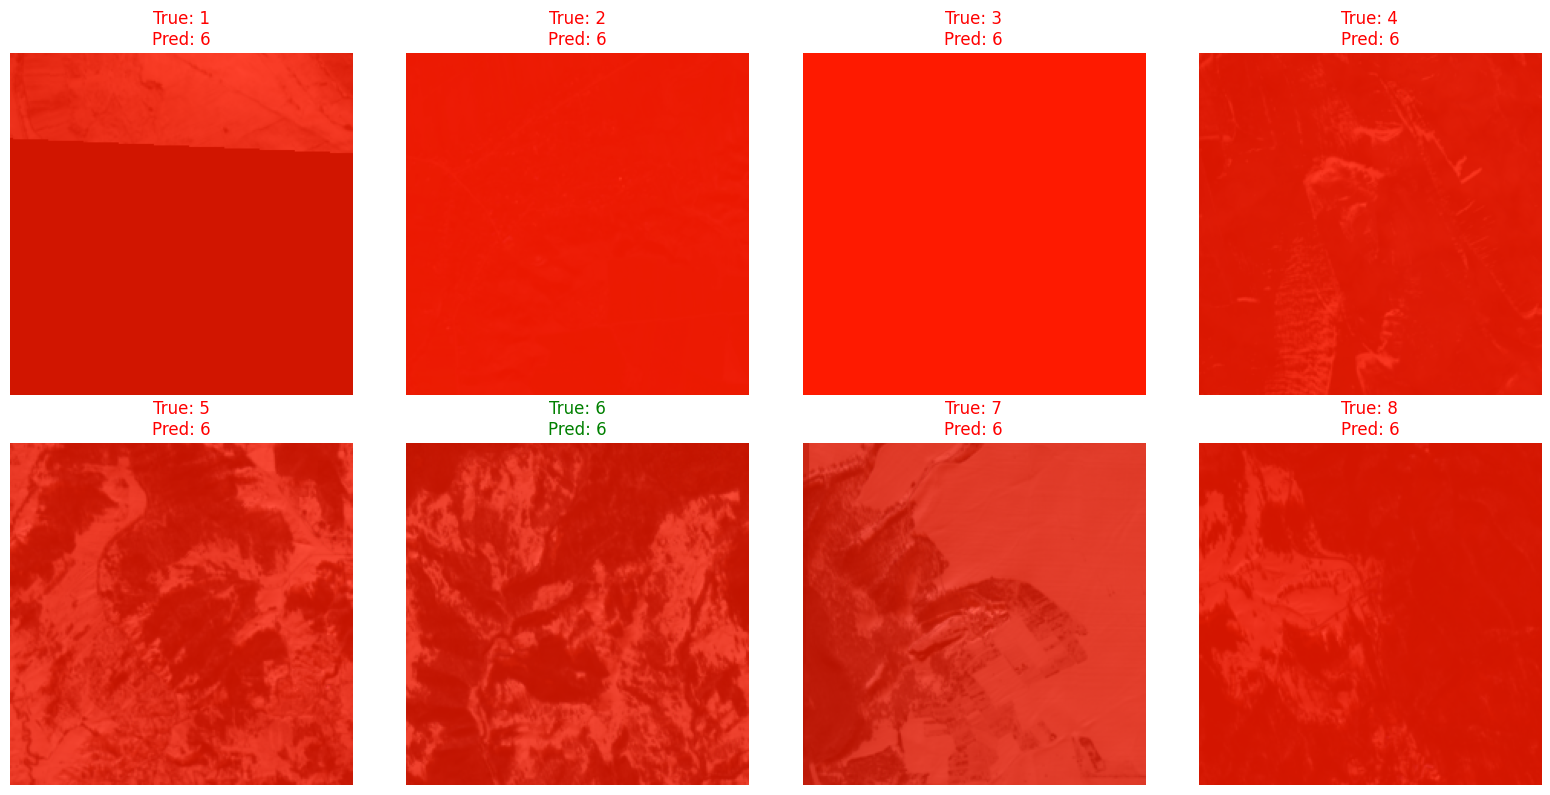

✅ Predictions visualized


In [ ]:
# Get predictions on test set
test_loader = datamodule.test_dataloader()
device = best_model.device

# Visualize some predictions
batch = next(iter(test_loader))
images = batch["image"].to(device)
labels = batch["label"].cpu().numpy()

with torch.no_grad():
    outputs = best_model(images)
    predictions = torch.argmax(outputs.output, dim=1).cpu().numpy()

# Plot predictions
class_names = task.hparams.class_names
n_samples = min(8, len(images))

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i in range(n_samples):
    # Get RGB bands for visualization (assuming bands 2,1,0 are R,G,B)
    img = images[i].cpu().numpy()
    if img.shape[0] >= 3:
        rgb = np.stack([img[2], img[1], img[0]], axis=-1)
        # Normalize for display
        rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-8)
    else:
        rgb = img[0]  # Use first band if not enough channels

    axes[i].imshow(rgb)
    true_label = class_names[labels[i]] if labels[i] < len(class_names) else str(labels[i])
    pred_label = class_names[predictions[i]] if predictions[i] < len(class_names) else str(predictions[i])

    color = 'green' if labels[i] == predictions[i] else 'red'
    axes[i].set_title(f'True: {true_label}\nPred: {pred_label}', color=color)
    axes[i].axis('off')

plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/predictions_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Predictions visualized")

ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 7


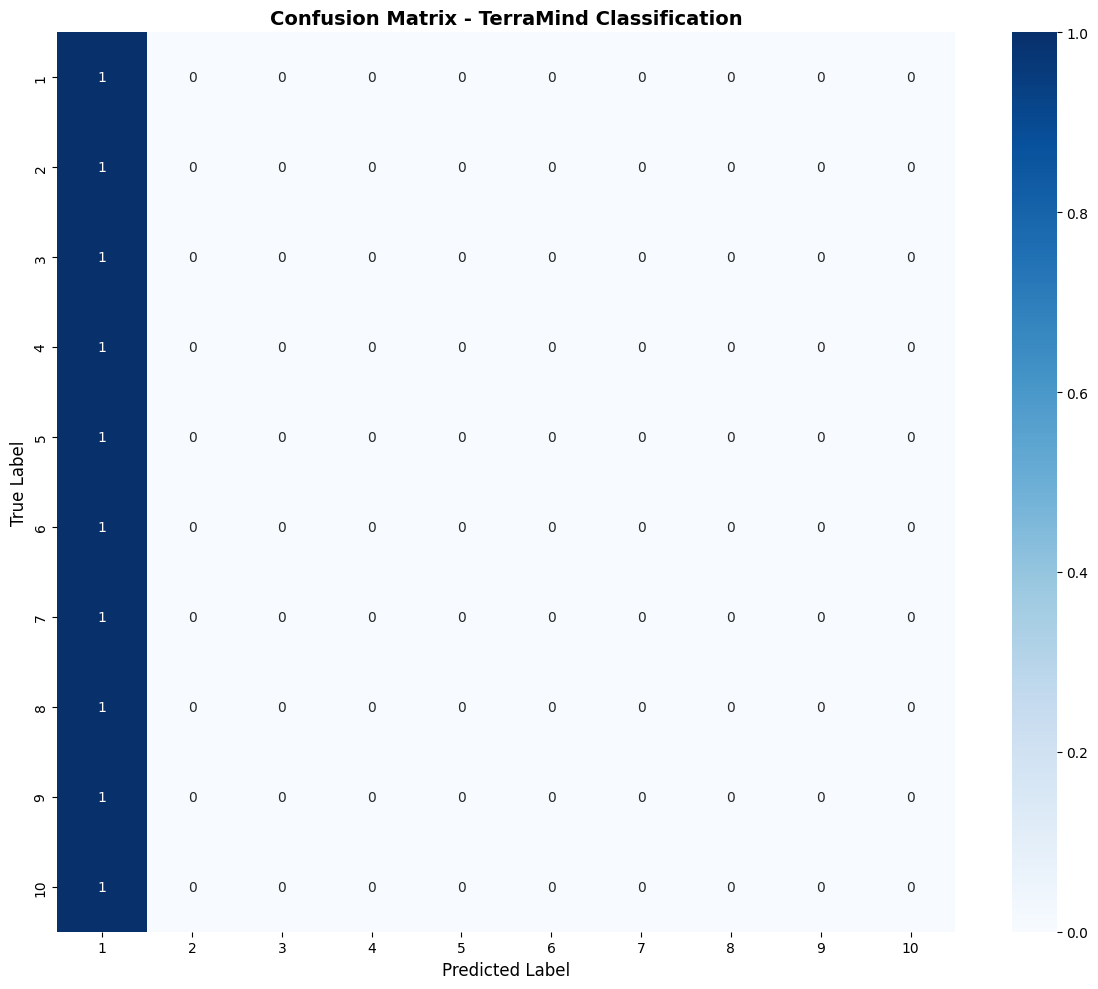


Classification Report:
              precision    recall  f1-score   support

           1       0.10      1.00      0.18         1
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1

    accuracy                           0.10        10
   macro avg       0.01      0.10      0.02        10
weighted avg       0.01      0.10      0.02        10


✅ Evaluation complete!


In [32]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Collect all predictions and labels
all_predictions = []
all_labels = []

best_model.eval()
with torch.no_grad():
    for batch in test_loader:
        images = batch["image"].to(device)
        labels = batch["label"].cpu().numpy()

        outputs = best_model(images)
        predictions = torch.argmax(outputs.output, dim=1).cpu().numpy()

        all_predictions.extend(predictions)
        all_labels.extend(labels)

# Create confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - TerraMind Classification', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Print classification report
print("\n" + "="*50)
print("Classification Report:")
print("="*50)
print(classification_report(all_labels, all_predictions, target_names=class_names))

print("\n✅ Evaluation complete!")